Spectral Feature Selection and Model Evaluation
This script performs SPA (Successive Projections Algorithm) feature selection on spectral data,then evaluates multiple regression models (PLS, Ridge, Lasso, ElasticNet) on the selected features.

Load and Prepare Data
X: Feature matrix (spectral data)
Y: Target matrix (chemical concentrations)
Reshape Y if it is 1D

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import warnings

X = np.loadtxt("dataF_final.csv", delimiter=",")
Y = np.loadtxt("dataC_final.csv", delimiter=",")
if Y.ndim == 1:
    Y = Y.reshape(-1, 1)
n_samples, n_features = X.shape
n_targets = Y.shape[1]

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

SPA Feature Selection
- SPA selects features iteratively to minimize multicollinearity while improving model prediction.
Starts with the feature that has the highest variance.
- Iteratively adds features that reduce RMSE when used with PLS regression.

In [3]:
def spa(X, Y, pls_components=2):
    selected = []
    remaining = list(range(X.shape[1]))

    first_var = np.argmax(np.var(X, axis=0))
    selected.append(first_var)
    remaining.remove(first_var)

    best_rmse = np.inf
    while True:
        rmses = []
        for f in remaining:
            features = selected + [f]
            pls = PLSRegression(n_components=min(len(features), pls_components))
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                pls.fit(X[:, features], Y)
            Y_pred = pls.predict(X[:, features])
            rmse = np.sqrt(mean_squared_error(Y, Y_pred))
            rmses.append(rmse)

        rmses = np.array(rmses)
        min_idx = np.argmin(rmses)

        if rmses[min_idx] >= best_rmse:
            break

        best_rmse = rmses[min_idx]
        best_feature = remaining[min_idx]
        selected.append(best_feature)
        remaining.remove(best_feature)

    return selected
selected_features = spa(X_scaled, Y, pls_components=2)
X_selected = X_scaled[:, selected_features]
print(f"SPA selected features ({len(selected_features)}): {selected_features}")

SPA selected features (62): [np.int64(63), 988, 544, 1838, 1317, 108, 401, 987, 1823, 650, 532, 64, 1516, 550, 1292, 1568, 1558, 1564, 165, 1817, 625, 68, 1468, 1563, 1187, 744, 2, 1821, 1207, 1759, 19, 374, 1343, 310, 386, 1511, 58, 74, 1576, 1154, 1618, 1184, 1617, 995, 373, 1572, 10, 24, 23, 39, 1470, 40, 1193, 1574, 1549, 1476, 926, 1146, 139, 0, 174, 1532]


Define Regression Models for Comparison
Models used:
 PLS: Partial Least Squares Regression
 Ridge: L2 Regularization
 Lasso: L1 Regularization
 ElasticNet: Combination of L1 and L2


In [5]:
models = {
    "PLS": PLSRegression(n_components=min(len(selected_features), 5)),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
}


Model Evaluation Function
Calculates:
 R²: Coefficient of determination
 RMSE: Root Mean Square Error
 REP%: Relative Error Percentage
 

In [7]:
def evaluate(model, X_input, Y_true):
    r2_list, rmse_list, rep_list = [], [], []
    for t in range(Y_true.shape[1]):
        y_true = Y_true[:, t]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_input, y_true)
        y_pred = model.predict(X_input)
        r2_list.append(r2_score(y_true, y_pred))
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_list.append(rmse)
        rep_list.append(rmse / np.mean(y_true) * 100)
    return r2_list, rmse_list, rep_list

Evaluate Each Model on SPA-Selected Features

In [9]:
for name, model in models.items():
    r2, rmse, rep = evaluate(model, X_selected, Y)
    print(f"\n{name} on SPA-selected features:")
    for i in range(n_targets):
        print(f"Target {i+1}: R²={r2[i]:.4f} | RMSE={rmse[i]:.4f} | REP%={rep[i]:.2f}")


PLS on SPA-selected features:
Target 1: R²=0.6098 | RMSE=1175.0213 | REP%=51.89
Target 2: R²=0.6626 | RMSE=1725.8202 | REP%=79.71
Target 3: R²=0.3799 | RMSE=1052.0458 | REP%=165.25
Target 4: R²=0.5924 | RMSE=1598.8254 | REP%=81.03
Target 5: R²=0.2053 | RMSE=1.6101 | REP%=229.94

Ridge on SPA-selected features:
Target 1: R²=0.6301 | RMSE=1144.1130 | REP%=50.53
Target 2: R²=0.6900 | RMSE=1654.3858 | REP%=76.41
Target 3: R²=0.4068 | RMSE=1028.9473 | REP%=161.63
Target 4: R²=0.6096 | RMSE=1564.5789 | REP%=79.29
Target 5: R²=0.2233 | RMSE=1.5918 | REP%=227.33

Lasso on SPA-selected features:
Target 1: R²=0.6316 | RMSE=1141.7297 | REP%=50.42
Target 2: R²=0.6934 | RMSE=1645.3048 | REP%=75.99
Target 3: R²=0.4121 | RMSE=1024.3174 | REP%=160.90
Target 4: R²=0.6113 | RMSE=1561.2276 | REP%=79.12
Target 5: R²=0.2164 | RMSE=1.5989 | REP%=228.33

ElasticNet on SPA-selected features:
Target 1: R²=0.6296 | RMSE=1144.7557 | REP%=50.56
Target 2: R²=0.6889 | RMSE=1657.2245 | REP%=76.54
Target 3: R²=0.406

Visualize Model Performance (R² Comparison)

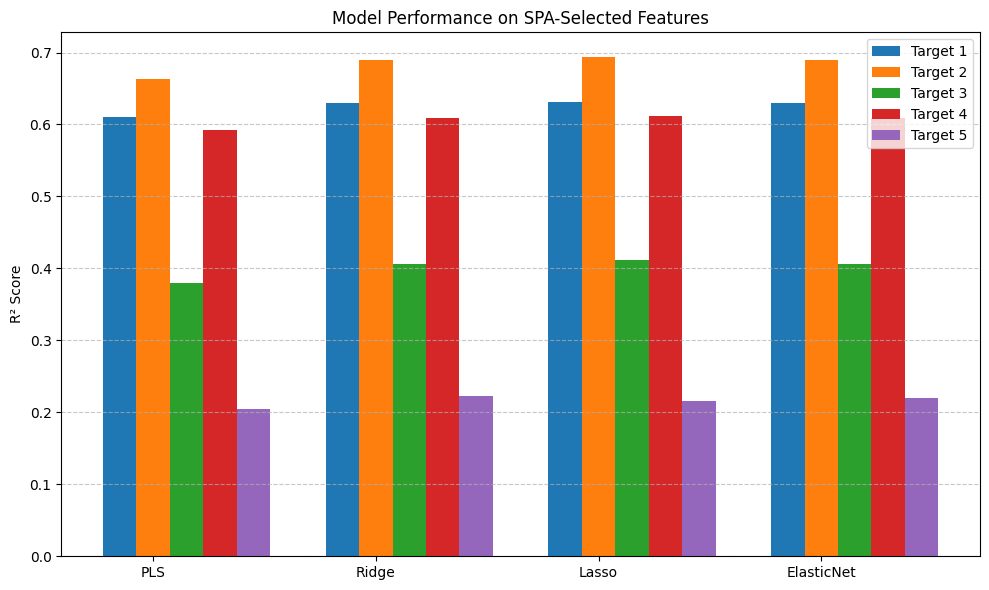

In [10]:
import matplotlib.pyplot as plt

model_names = []
r2_scores = []

for name, model in models.items():
    r2, rmse, rep = evaluate(model, X_selected, Y)
    model_names.append(name)
    r2_scores.append(r2)

r2_scores = np.array(r2_scores)  

x = np.arange(len(model_names))
width = 0.15

plt.figure(figsize=(10, 6))
for i in range(n_targets):
    plt.bar(x + i*width, r2_scores[:, i], width, label=f"Target {i+1}")

plt.xticks(x + width, model_names)
plt.ylabel("R² Score")
plt.title("Model Performance on SPA-Selected Features")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()